# Dynamics of Software Development and Archiving

## Import libraries

In [98]:
import datetime
import json

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from tqdm import tqdm

## Load data

In [20]:
df = pd.read_csv("../results/articles_info_pubmed_github_software_heritage.tsv", sep="\t", index_col="PMID")
df.iloc[0,]

publication_date                                            2010-12-17
DOI                                      10.1093/bioinformatics/btq693
journal                               Bioinformatics (Oxford, England)
title                SAIL--a software system for sample and phenoty...
abstract             The Sample avAILability system-SAIL-is a web b...
GitHub_link_raw                                       github.com/sail.
GitHub_link_clean                             https://github.com/sail/
GitHub_repo_owner                                                 sail
GitHub_repo_name                                                   NaN
date_repo_created                                                  NaN
date_repo_updated                                                  NaN
is_fork                                                          False
is_archived                                                      False
date_archived                                                      NaN
Name: 

### Create a file with the dataset statistics

In [21]:
with open("../results/data_collection_summary.txt", "w") as f:
    f.write(f"Number of articles in PubMed with 'github.com' in abstract: {len(df)}\n")
    
    df = df.dropna(subset=["publication_date"])
    f.write(f"Number of articles after removing the ones without publication date: {len(df)}\n")
       
    df = df.dropna(subset=["GitHub_repo_owner"])
    f.write(f"Articles after removing the ones without GitHub link : {len(df)}\n")
    
    df = df.dropna(subset=["GitHub_repo_name"])
    f.write(f"Articles after removing the ones with the wrong GitHub link (no repository name) : {len(df)}\n")
    
    df = df.dropna(subset=["date_repo_created"])
    f.write(f"Articles after removing the ones with the repository deleted or wrong link (unable to access with GitHub API): {len(df)}\n")
    
    df = df[df["is_fork"] == False]
    f.write(f"Articles after removing the GitHub forks : {len(df)}\n") 
    
    f.write(f"Repositories not archived in Software Heritage: {len(df[df['is_archived'] == False])}\n")
    f.write(f"Repositories archived in Software Heritage: {len(df[df['is_archived'] == True])}\n")

### Add supplementary columns to the dataset

In [22]:
# Convert date fields (as string) to proper dates
df["publication_date"] = pd.to_datetime(df["publication_date"])
df["date_repo_created"] = pd.to_datetime(df["date_repo_created"])
df["date_repo_updated"] = pd.to_datetime(df["date_repo_updated"])         

df["Days_before"] = (df["date_repo_created"] - df["publication_date"]).dt.days
df["Days_after"] = (df["date_repo_updated"] - df["publication_date"]).dt.days
df["Days_dev"] = (df["date_repo_updated"] - df["date_repo_created"]).dt.days
df["Updates"] = df["Days_after"].apply(lambda x: 1 if x>0 else 0)

In [6]:
# https://github.com/sermeor/The-Analysis-Kid/commits/main?after=69a4b677398c359efc878ba9ffe64028e3d11c1a+34&branch=main&qualified_name=refs%2Fheads%2Fmain
# 31890138

### Plot the annual Software Heritage archiving statistics (Fig. 1)

In [101]:
# Get the total number of articles / software per year
# and the number of archived software.
archive_dist = (df
  .groupby([df['publication_date'].dt.year])
  .agg(
      total=("is_archived", "count"),
      archived=("is_archived", "sum")
  )
)
# Remove current year because it is incomplete.
current_year = datetime.date.today().year
archive_dist = archive_dist.drop(index=current_year, errors="ignore")
# Display first lines for control
print(archive_dist.head())

                  total  archived
publication_date                 
2010                  5         3
2011                 14        14
2012                 40        35
2013                 76        66
2014                169       158


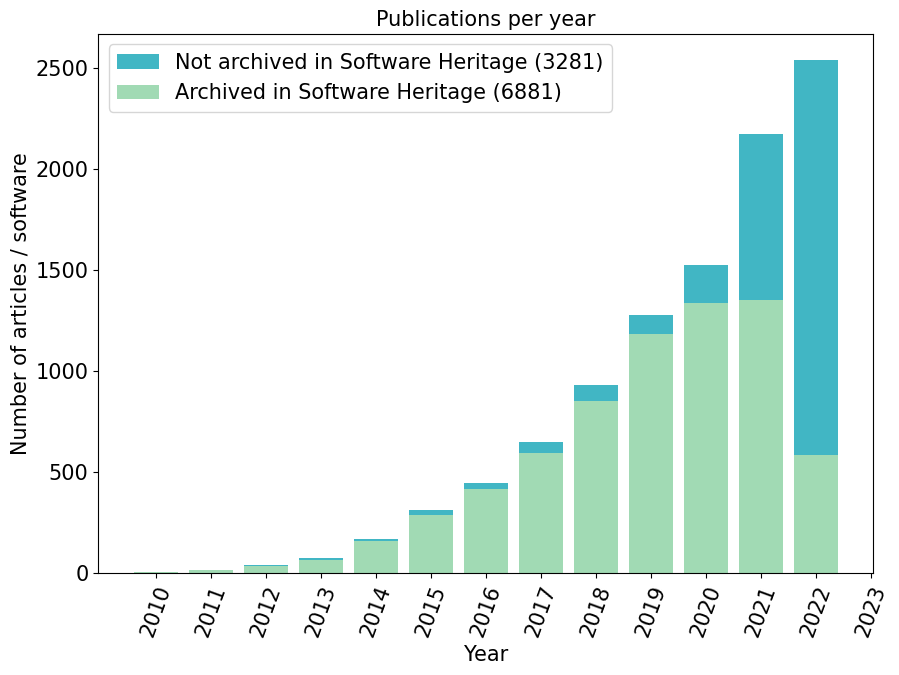

In [94]:
plt.rcParams['text.usetex'] = False
fig, ax = plt.subplots(figsize=(10, 7))

ax.bar(archive_dist.index, archive_dist["total"], color="#41b6c4")
ax.bar(archive_dist.index, archive_dist["archived"], color="#a1dab4")

ax.set_xlabel("Year", fontsize=15, fontfamily='sans-serif')
ax.set_ylabel("Number of articles / software", fontsize=15, fontfamily='sans-serif')
ax.set_title("Publications per year", fontsize=15, fontfamily='sans-serif')
ax.legend([
    f"Not archived in Software Heritage ({sum(archive_dist['total'] - archive_dist['archived'])})",
    f"Archived in Software Heritage ({sum(archive_dist['archived'])})"
    ],fontsize=15
)
plt.xticks(years, rotation=70)
ax.tick_params(axis="y", labelsize=15) 
ax.tick_params(axis="x", labelsize=15) 

plt.savefig("../results/stat_swh.png")
plt.show()

### Plot the timeline of software development (Fig.2)

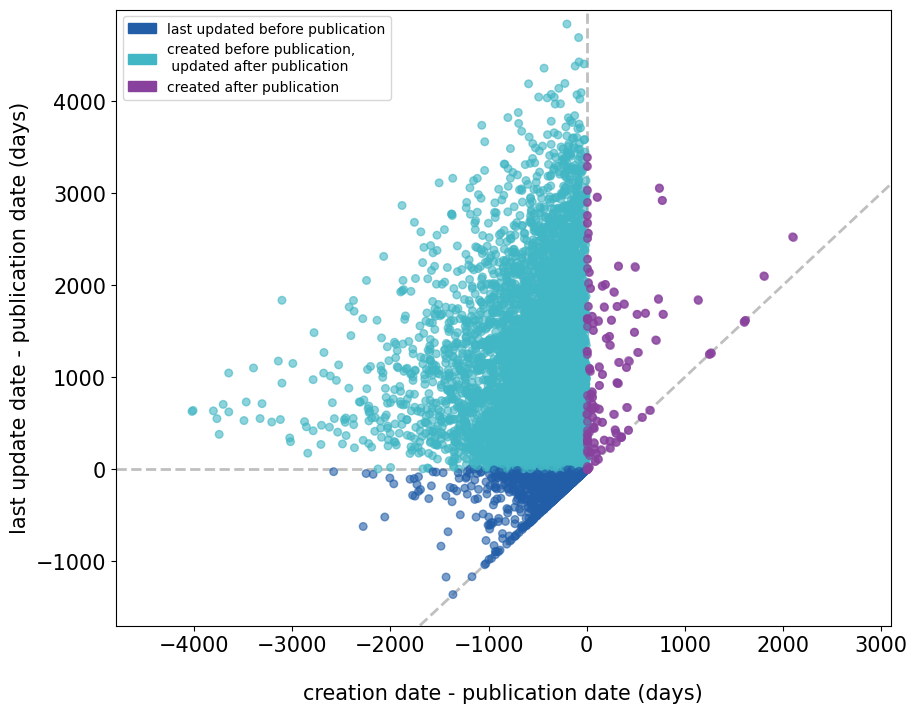

In [96]:
plt.rcParams['text.usetex'] = False
color = [0] * len(df)
alpha = [0] * len(df)

for index, row in enumerate(df["Days_before"]):
    if row < 0 and df["Days_after"].iloc[index] <= 0:
        color[index] = '#225ea8'
        alpha[index] = 0.6
    if row < 0 and df["Days_after"].iloc[index] > 0:
        color[index] = '#41b6c4'
        alpha[index] = 0.6
    if row >= 0:
        color[index] = '#88419d'
        alpha[index] = 0.6

fig, ax = plt.subplots(1, figsize=(10, 8))

ax.scatter(df['Days_before'], df['Days_after'], alpha = alpha, s = 30, color = color)
ax.scatter(df[df['Days_before']>=0]['Days_before'], df[df['Days_before']>=0]['Days_after'], alpha = 0.6, s = 30, color = '#88419d')

ax.axvline(x = 0, ymin = 0.26, ymax = 1, color = 'gray', linestyle = '--', linewidth = 2, alpha = 0.5, zorder = 0)  
ax.axhline(y = 0, xmin = 0, xmax = 0.6, color = 'gray', linestyle = '--', linewidth = 2, alpha = 0.5, zorder = 0)
ax.axline((0, 0),(1, 1), color = 'gray', linestyle = '--', linewidth = 2, alpha = 0.5, zorder = 0)

#ax.set_xlabel("\nrepository \\textbf{creation} date - publication date (days)", fontdict={'fontsize': 15, 'fontfamily': 'sans-serif'})
#ax.set_ylabel("repository last \\textbf{update} date - publication date (days)", fontdict={'fontsize': 15, 'fontfamily': 'sans-serif'})

ax.set_xlabel("\ncreation date - publication date (days)", fontdict={'fontsize': 15, 'fontfamily': 'sans-serif'})
ax.set_ylabel("last update date - publication date (days)", fontdict={'fontsize': 15, 'fontfamily': 'sans-serif'})

ax.set_xlim([-4800, 3100])
ax.set_ylim([-1700, 4999])

green_patch = mpatches.Patch(color='#88419d', label='created after publication')
lblue_patch = mpatches.Patch(color='#41b6c4', label='created before publication,\n updated after publication')
dblue_patch = mpatches.Patch(color='#225ea8', label='last updated before publication')
patches = [dblue_patch, lblue_patch, green_patch]
ax.legend(handles=patches, loc='upper left')
ax.tick_params(axis='y', labelsize=15) 
ax.tick_params(axis='x', labelsize=15) 

plt.savefig("../results/stat_dynam.png")
plt.show()

### Plot the quantification of the fig. 2 (Fig. 3)

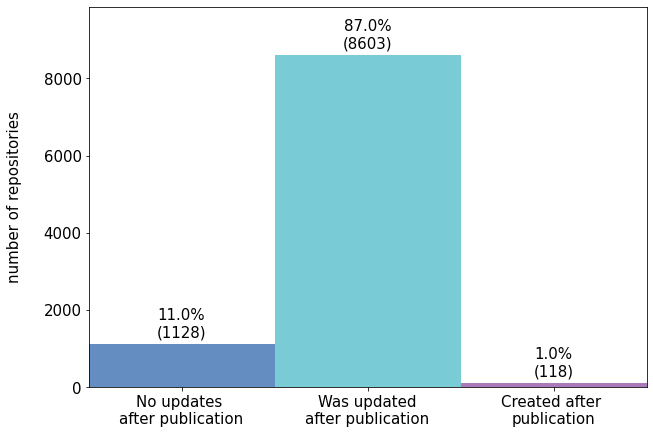

In [9]:
plt.rcParams['text.usetex'] = False

fig, ax = plt.subplots(figsize=(10, 7))

after, no_update, update, forks = 0, 0, 0, 0
for index, row in df.iterrows():
    if row["Days_before"]>=0:
        after += 1 
    elif row["Days_before"]<0 and row["Days_after"]<0:
        no_update += 1
    elif row["Days_before"]<0 and row["Days_after"]>=0:
        update += 1
    if row["Fork"] == 1:
        forks += 1
n=0

data = [no_update, update, after]
bin_edges = [0.5, 1.5, 2.5]
labels = ['No updates \nafter publication', 'Was updated\nafter publication', 'Created after \npublication']
color=['#225ea8', '#41b6c4', '#88419d']
ax.bar(bin_edges[:], data, width=1, color=color, alpha = 0.7)
ax.set_xlim(0, 3)
#ax.set_yscale('log')
ax.set_xticks([0.5, 1.5, 2.5], labels, fontsize=15, fontfamily='sans-serif')


for i, datum in enumerate(data):
    ax.text(i+0.5, datum+100, f'{str(round(100*datum/sum(data),0))}%\n({str(datum)})', ha='center', va='bottom', fontdict={'fontsize': 15, 'fontfamily': 'sans-serif'})

ax.set_ylim([0, len(df)])
ax.set_ylabel('number of repositories\n', fontdict={'fontsize': 15, 'fontfamily': 'sans-serif'})
ax.tick_params(axis='y', labelsize=15) 

plt.savefig("../data/images/stat_hist.png")
plt.show()

### Plot the projections of the fig. 2 (Fig. 4 a-c)

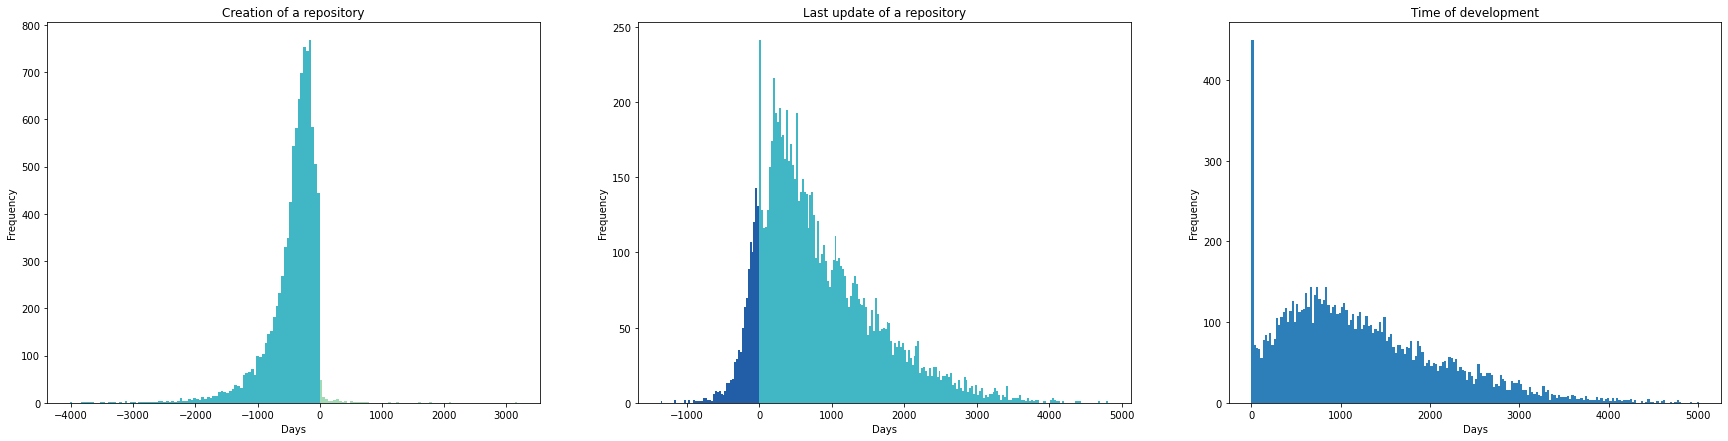

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(30, 7))

axs[0].hist(df[df['Days_before']>=0]['Days_before'], bins=round(40 / -min(df['Days_before']) * (max(df['Days_before'])-min(df['Days_before']))), color='#a1dab4')
axs[0].hist(df[df['Days_before']<0]['Days_before'], bins=round(40 / max(df['Days_before']) * (max(df['Days_before'])-min(df['Days_before']))), color='#41b6c4')
axs[1].hist(df[df['Days_after']>=0]['Days_after'], bins=round(40 / -min(df['Days_after']) * (max(df['Days_after'])-min(df['Days_after']))), color='#41b6c4')
axs[1].hist(df[df['Days_after']<0]['Days_after'], bins=round(40 / max(df['Days_after']) * (max(df['Days_after'])-min(df['Days_after']))), color='#225ea8')
axs[2].hist((df['Days_dev']), bins=200, color='#2c7fb8')

axs[0].set_xlabel('Days')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Creation of a repository')
axs[1].set_xlabel('Days')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Last update of a repository')
axs[2].set_xlabel('Days')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Time of development')

plt.savefig("../data/images/stat_dev.png")
plt.show()

### Plot the fig. 5b in a larger format (Fig. 5)

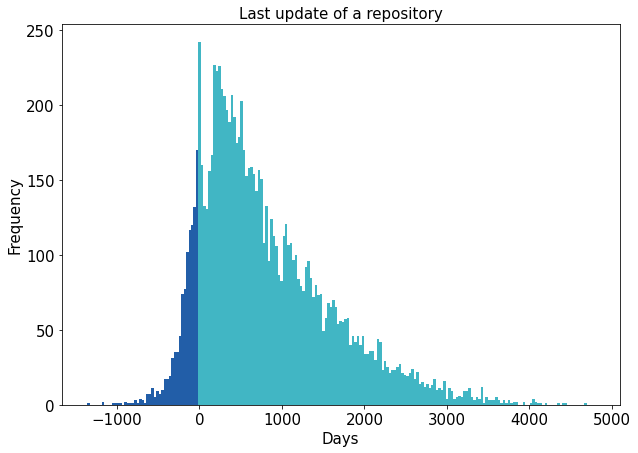

In [11]:
fig, axs = plt.subplots(figsize=(10, 7))

bin_size = 30
bin_edges = np.arange(min(df['Days_after']), max(df['Days_after']), bin_size)
axs.hist(df['Days_after'], bins = bin_edges, color='#41b6c4')

#bin_edges = np.arange(min(df[df['Days_after']>0]['Days_after']), max(df[df['Days_after']>0]['Days_after']), bin_size)
#axs.hist(df[df['Days_after']>0]['Days_after'], bins = bin_edges, color='#41b6c4', alpha=0.6)

bin_edges = np.arange(min(df[df['Days_after']<=0]['Days_after']), max(df[df['Days_after']<=0]['Days_after']), bin_size)
axs.hist(df[df['Days_after']<=0]['Days_after'], bins = bin_edges, color='#225ea8', )


axs.set_xlabel('Days', fontsize=15, fontfamily='sans-serif')
axs.set_ylabel('Frequency', fontsize=15, fontfamily='sans-serif')
axs.set_title('Last update of a repository',fontsize=15, fontfamily='sans-serif')
axs.tick_params(axis='y', labelsize=15) 
axs.tick_params(axis='x', labelsize=15) 

plt.savefig("../data/images/stat_last_updt.png")
plt.show()